In [24]:
# Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import sys
sys.path.insert(0,'../')  # add previous directory to path to load constants module
import constants as const

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
print(tf.__version__)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import statistics


2.15.0


In [25]:
# Import dataset using pandas

raw_dataset = pd.read_csv('../Datasets/dataset_reduced_paper.csv')
dataset = raw_dataset.copy()
print("Shape of dataset: "+str(dataset.shape))
dataset.tail()

Shape of dataset: (602649, 17)


,turbine,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P
602644,R80736,944.234446,19.290001,227.44,15.730000,20.680000,19.170000,19.920000,222.05,-5.37,7.27,1.801180,29.480000,222.05,222.05,10823.5,2043069.9
602645,R80736,959.131349,19.059999,227.44,15.600000,20.799999,19.299999,20.049999,221.98,-5.44,7.23,1.798038,29.379999,221.98,221.98,10843.5,2043060.1
602646,R80736,995.227747,17.000000,201.95,16.389999,21.010000,19.920000,20.469999,203.55,1.60,8.87,1.801180,32.730000,203.55,203.55,10853.3,2048070.1
602647,R80711,963.715011,16.000000,242.56,15.170000,21.120001,19.840000,20.480000,237.59,-4.99,9.31,1.801180,26.010000,237.59,237.59,10817.3,2041980.0
602648,R80736,1008.978735,17.000000,225.25,16.709999,21.280001,19.719999,20.500000,219.62,-5.62,10.31,1.799085,27.200001,219.62,219.62,10837.3,2043120.0


In [27]:
# Clean dataset of NaN values
#dataset.isna().sum()
print(dataset.isna().sum())
dataset = dataset.dropna()

turbine                0
theta                  0
hub_temperature        0
nacelle_angle          0
nacelle_temperature    0
V1                     0
V2                     0
V                      0
Wind_angle             0
Vane_angle             0
Out_temperature        0
W                      0
Rotor_temperature      0
Wind_angle_c           0
nacelle_angle_c        0
T                      0
P                      0
dtype: int64


In [28]:
# One-hot encode categorical columns

dataset['turbine'] = dataset['turbine'].map({1:'R80711', 2:'R80721',3:'R80736', 4:'R80790'})
dataset = pd.get_dummies(dataset, columns=['turbine'], prefix='', prefix_sep='')
dataset.tail()

,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P
602644,944.234446,19.290001,227.44,15.730000,20.680000,19.170000,19.920000,222.05,-5.37,7.27,1.801180,29.480000,222.05,222.05,10823.5,2043069.9
602645,959.131349,19.059999,227.44,15.600000,20.799999,19.299999,20.049999,221.98,-5.44,7.23,1.798038,29.379999,221.98,221.98,10843.5,2043060.1
602646,995.227747,17.000000,201.95,16.389999,21.010000,19.920000,20.469999,203.55,1.60,8.87,1.801180,32.730000,203.55,203.55,10853.3,2048070.1
602647,963.715011,16.000000,242.56,15.170000,21.120001,19.840000,20.480000,237.59,-4.99,9.31,1.801180,26.010000,237.59,237.59,10817.3,2041980.0
602648,1008.978735,17.000000,225.25,16.709999,21.280001,19.719999,20.500000,219.62,-5.62,10.31,1.799085,27.200001,219.62,219.62,10837.3,2043120.0


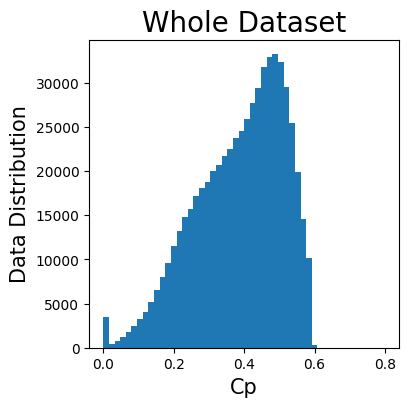

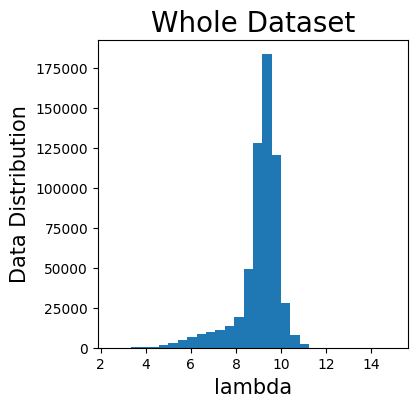

,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P,Cp,lambda
602644,944.234446,19.290001,227.44,15.730000,20.680000,19.170000,19.920000,222.05,-5.37,7.27,1.801180,29.480000,222.05,222.05,10823.5,2043069.9,0.079908,3.707248
602645,959.131349,19.059999,227.44,15.600000,20.799999,19.299999,20.049999,221.98,-5.44,7.23,1.798038,29.379999,221.98,221.98,10843.5,2043060.1,0.078364,3.676787
602646,995.227747,17.000000,201.95,16.389999,21.010000,19.920000,20.469999,203.55,1.60,8.87,1.801180,32.730000,203.55,203.55,10853.3,2048070.1,0.073819,3.607639
602647,963.715011,16.000000,242.56,15.170000,21.120001,19.840000,20.480000,237.59,-4.99,9.31,1.801180,26.010000,237.59,237.59,10817.3,2041980.0,0.073492,3.605878
602648,1008.978735,17.000000,225.25,16.709999,21.280001,19.719999,20.500000,219.62,-5.62,10.31,1.799085,27.200001,219.62,219.62,10837.3,2043120.0,0.073318,3.598171


In [29]:
# Add Cp and lambda to the dataset

def Cp_fromP(Pturbina, Vw):

    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp

def lambd(Vw, Wwt):

    lambd = Wwt * const.R / Vw

    return lambd

Cp_data = Cp_fromP(dataset['P'][:],dataset['V'][:])
dataset['Cp'] = Cp_data
lambd_data = lambd(dataset['V'][:], dataset['W'][:])
dataset['lambda'] = lambd_data

plt.figure(figsize=(4,4))
plt.hist(Cp_data, range=[0.0, 0.8], bins=50)
plt.xlabel('Cp',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Histogram of lambda
plt.figure(figsize=(4,4))
plt.hist(lambd_data, range=[2.5, 15], bins=30)
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

dataset.tail()

In [30]:
# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
theta,602649.0,-4.643517,342.545648,-61.879442,-57.295780,-56.722822,-51.566200,5.314757e+03
hub_temperature,602649.0,19.060174,5.838598,4.050000,14.170000,18.719999,23.000000,3.900000e+01
nacelle_angle,602649.0,180.414785,92.988829,0.000000,102.290000,200.679990,246.100010,3.600000e+02
nacelle_temperature,602649.0,24.595032,6.192875,1.490000,20.639999,25.110001,28.969999,4.291000e+01
V1,602649.0,6.306669,2.018830,0.000000,4.950000,5.870000,7.130000,2.128000e+01
V2,602649.0,6.321526,1.956744,0.000000,4.990000,5.900000,7.140000,2.015000e+01
V,602649.0,6.314169,1.982688,0.230000,4.970000,5.890000,7.130000,2.050000e+01
Wind_angle,602649.0,180.053769,92.830444,0.000000,102.270000,199.610000,245.160000,3.600000e+02
Vane_angle,602649.0,-0.184985,9.427393,-179.340000,-5.310000,-0.460000,4.800000,1.797500e+02
Out_temperature,602649.0,11.473260,7.091906,-6.950000,5.960000,10.910000,16.330000,3.828000e+01


In [31]:
# Normalization 
# Cp in the range [0,1]. Originally, it was in [0,Cp_max]
# Rest of the variables with mean 0 and std 1

print(dataset.describe().transpose()[['mean', 'std']])

x_mean = np.nanmean( dataset, axis=0)
x_std = np.nanstd( dataset, axis=0 )

column_name = dataset.columns.values
Cp_column = column_name[5]
#print(Cp_column)

Cp_max = 0.5926
dataset_norm = dataset.copy()
icol = 0
for col in column_name:
    if(col!='Cp'): # mean 0 and std 1
        dataset_norm[col]=(dataset[col]-x_mean[icol])/x_std[icol]        
    else: # Cp in [0,1]
        dataset_norm[col]=dataset[col]/Cp_max
    icol = icol+1

print()
print("Normalized dataset")
print(dataset_norm.describe().transpose()[['mean', 'std']])

                              mean            std
theta                    -4.643517     342.545648
hub_temperature          19.060174       5.838598
nacelle_angle           180.414785      92.988829
nacelle_temperature      24.595032       6.192875
V1                        6.306669       2.018830
V2                        6.321526       1.956744
V                         6.314169       1.982688
Wind_angle              180.053769      92.830444
Vane_angle               -0.184985       9.427393
Out_temperature          11.473260       7.091906
W                         1.362470       0.318853
Rotor_temperature        28.486577       4.714501
Wind_angle_c            179.627065      92.421807
nacelle_angle_c         179.767785      92.504951
T                      2646.532389    2258.267705
P                    444860.879260  446349.165241
Cp                        0.386876       0.124435
lambda                    9.004813       1.167138

Normalized dataset
                             m

In [32]:
# load existing Cp model
Cp_model = tf.keras.models.load_model('../Models/Cp3D_sigmoid_model.h5')
Cp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               512       
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17153 (67.00 KB)
Trainable params: 17153 (67.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
# load existing Pphys model
from keras import backend as K
from keras.layers import Input, Lambda
from keras.layers import Concatenate
V_mean = 6.314169410268349
V_std = 1.9826865496833004

Pphys_model = tf.keras.models.load_model('../Models/Pphys.h5')
Pphys_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 xphys (InputLayer)          [(None, 3)]                  0         []                            
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['xphys[0][0]']               
                                                                                                  
 sequential_1 (Sequential)   (None, 1)                    17153     ['xphys[0][0]']               
                                                                                                  
 lambda_3 (Lambda)           (None, 1)                    0         ['lambda[0][0]',              
                                                                     'sequential_1[0][0]']    

In [34]:
# Define input features of P_phys model
dataset_copy = dataset_norm.copy()
xphys = dataset_copy[['V','theta','W']]

# Evaluate power in normalized units
P_phys = Pphys_model.predict(xphys).flatten()

18833/18833 [==============================] - 8s 436us/step


In [35]:
# Add physical and residual power to the dataset
dataset['P_phys'] = P_phys
dataset.describe().transpose()
#dataset['P_res'] = dataset['P_phys'] - dataset['P']
dataset['P_res'] = dataset['P'] - dataset['P_phys']
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
theta,602649.0,-4.643517,342.545648,-6.187944e+01,-57.295780,-5.672282e+01,-51.566200,5.314757e+03
hub_temperature,602649.0,19.060174,5.838598,4.050000e+00,14.170000,1.872000e+01,23.000000,3.900000e+01
nacelle_angle,602649.0,180.414785,92.988829,0.000000e+00,102.290000,2.006800e+02,246.100010,3.600000e+02
nacelle_temperature,602649.0,24.595032,6.192875,1.490000e+00,20.639999,2.511000e+01,28.969999,4.291000e+01
V1,602649.0,6.306669,2.018830,0.000000e+00,4.950000,5.870000e+00,7.130000,2.128000e+01
V2,602649.0,6.321526,1.956744,0.000000e+00,4.990000,5.900000e+00,7.140000,2.015000e+01
V,602649.0,6.314169,1.982688,2.300000e-01,4.970000,5.890000e+00,7.130000,2.050000e+01
Wind_angle,602649.0,180.053769,92.830444,0.000000e+00,102.270000,1.996100e+02,245.160000,3.600000e+02
Vane_angle,602649.0,-0.184985,9.427393,-1.793400e+02,-5.310000,-4.600000e-01,4.800000,1.797500e+02
Out_temperature,602649.0,11.473260,7.091906,-6.950000e+00,5.960000,1.091000e+01,16.330000,3.828000e+01


In [36]:
# Normalize dataset
#P_phys_norm = (P_phys - dataset['P_phys'].mean())/dataset['P_phys'].std() # Normalize Power  
P_phys_norm = (P_phys - P_phys.mean())/P_phys.std() # Normalize Power  
dataset_norm['P_phys'] = P_phys_norm
dataset_norm['P_res'] = ( dataset['P_res'] - dataset['P_res'].mean() )/dataset['P_res'].std()
dataset_norm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
theta,602649.0,2.263742e-17,1.000001,-0.167090,-0.153709,-0.152036,-0.136982,15.529038
hub_temperature,602649.0,7.081741e-16,1.000001,-2.570855,-0.837560,-0.058263,0.674790,3.415176
nacelle_angle,602649.0,-1.786470e-16,1.000001,-1.940179,-0.840153,0.217932,0.706378,1.931257
nacelle_temperature,602649.0,-3.561621e-16,1.000001,-3.730909,-0.638643,0.083155,0.706452,2.957428
V1,602649.0,5.070783e-16,1.000001,-3.123925,-0.672008,-0.216298,0.407826,7.416842
V2,602649.0,1.992093e-16,1.000001,-3.230637,-0.680481,-0.215422,0.418284,7.067088
V,602649.0,4.829317e-17,1.000001,-3.068649,-0.677954,-0.213937,0.411477,7.154853
Wind_angle,602649.0,4.199242e-16,1.000001,-1.939600,-0.837913,0.210666,0.701346,1.938441
Vane_angle,602649.0,-3.372033e-18,1.000001,-19.003680,-0.543631,-0.029172,0.528777,19.086414
Out_temperature,602649.0,7.949508e-16,1.000001,-2.597789,-0.777402,-0.079423,0.684829,3.779909


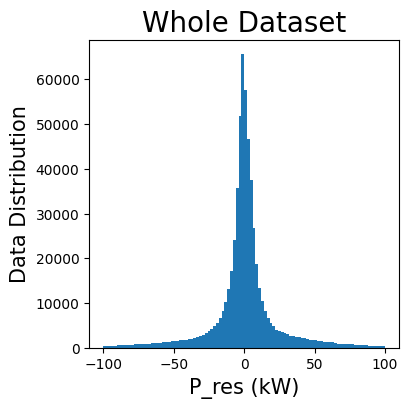

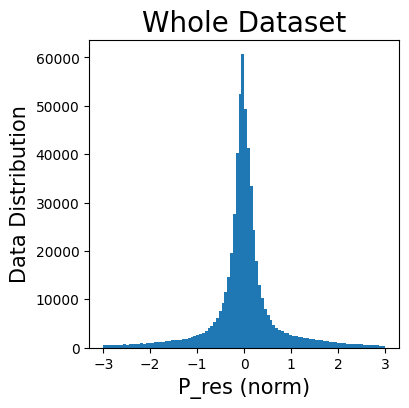

In [37]:
# Plot distribution of P_res in kW
Pres_data = dataset['P_res']
plt.figure(figsize=(4,4))
#plt.hist(Pres_data, range=[2.5, 15], bins=100)
plt.hist(Pres_data/1000, range=[-100, 100], bins=100)
plt.xlabel('P_res (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Normalized Pres
Pres_norm = dataset_norm['P_res']
plt.figure(figsize=(4,4))
#plt.hist(Pres_data, range=[2.5, 15], bins=100)
plt.hist(Pres_norm, range=[-3, 3], bins=100)
plt.xlabel('P_res (norm)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

In [44]:
dataset_imp = dataset.copy()
dataset_imp = dataset_imp[['V','W','Out_temperature','P_res']]
print(dataset_imp.columns)
print(dataset_imp.describe().transpose())

Index(['V', 'W', 'Out_temperature', 'P_res'], dtype='object')
                    count        mean           std        min          25%  \
V                602649.0    6.314169      1.982688       0.23     4.970000   
W                602649.0    1.362470      0.318853       0.00     1.092227   
Out_temperature  602649.0   11.473260      7.091906      -6.95     5.960000   
P_res            602649.0  590.293164  30315.169909 -373246.75 -5862.369375   

                          50%          75%            max  
V                5.890000e+00     7.130000      20.500000  
W                1.348790e+00     1.665044       1.803274  
Out_temperature  1.091000e+01    16.330000      38.279999  
P_res           -2.576112e-13  6546.468750  423921.875000  


In [46]:
# Split the data into training and test sets
train_dataset = dataset_imp.sample(frac=0.8, random_state=10)
test_dataset = dataset_imp.drop(train_dataset.index)

train_features = train_dataset[['V','W','Out_temperature']]
test_features = test_dataset[['V','W','Out_temperature']]
train_labels = train_dataset.pop('P_res')
test_labels = test_dataset.pop('P_res')

print(train_features.shape)
print(train_labels.shape)

(482119, 3)
(482119,)


Fitted parameters: Ct = -1200.1845398687988, T0 = 11.909083849890532


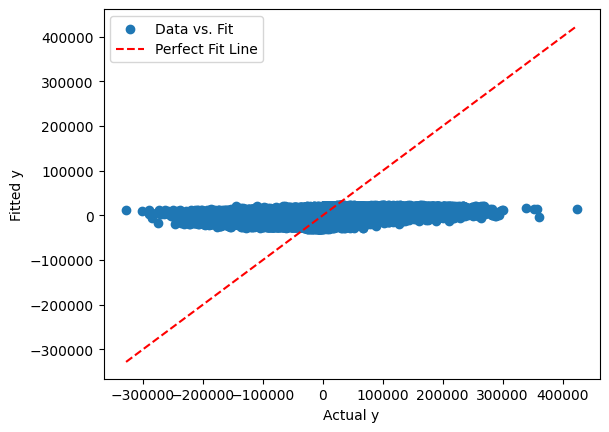

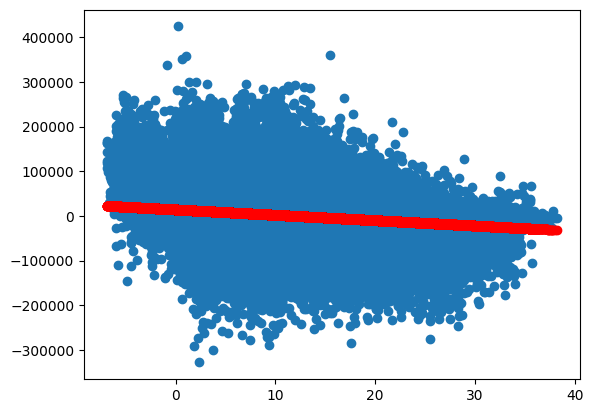

In [116]:
from scipy.optimize import curve_fit

def Pres_function(T, Ct, T0):
    return Ct*(T-T0)

T_data = train_features['Out_temperature'].to_numpy()
y_target = train_labels.to_numpy()
initial_guesses = [1,1]

params, params_covariance = curve_fit(Pres_function, T_data, y_target, p0=initial_guesses)

Ct, T0 = params
print(f"Fitted parameters: Ct = {Ct}, T0 = {T0}")
y_fitted = Pres_function(T_data, *params)
plt.scatter(y_target, y_fitted, label='Data vs. Fit')
plt.plot([min(y_target), max(y_target)], [min(y_target), max(y_target)], 'r--', label='Perfect Fit Line')
plt.xlabel('Actual y')
plt.ylabel('Fitted y')
plt.legend()
plt.show()

plt.scatter(T_data, y_target, label='Data vs Out temperature')
plt.plot(T_data, y_fitted, 'ro')
plt.show()

In [122]:

def Pres_function(inputs, P_offset, Cw, W0, Cv, V0, Ct, T0):
    V,W,T = inputs
    return P_offset + Cw*(W-W0) + Cv*(V-V0)**2 + Ct*(T-T0)

x_data = train_features.to_numpy()
y_target = train_labels.to_numpy()
initial_guesses = [590,1000,1.36,1000,6.31,-1200,11]

params, params_covariance = curve_fit(Pres_function, (x_data[:,0],x_data[:,1],x_data[:,2]),y_target, p0=initial_guesses)

Fitted parameters: P_offset = -26679.808340847754, Cw = -23338.52694689907, W0 = 2.535478308863946, Cv = -493.15273084641836, V0 = 10.441115665015436, Ct = -1259.8342307038881, T0 = 19.543512715112666


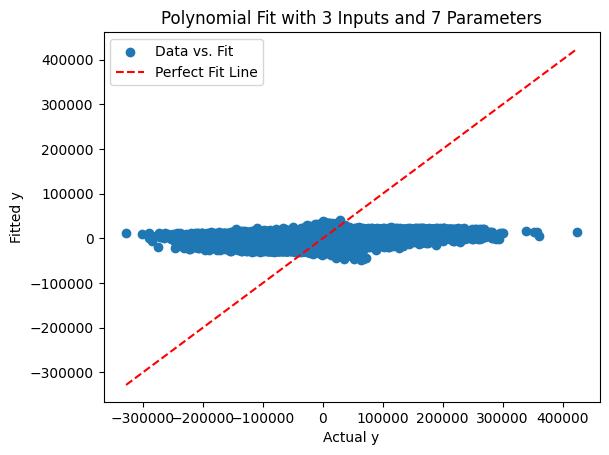

In [123]:
P_offset, Cw, W0, Cv, V0, Ct, T0 = params
print(f"Fitted parameters: P_offset = {P_offset}, Cw = {Cw}, W0 = {W0}, Cv = {Cv}, V0 = {V0}, Ct = {Ct}, T0 = {T0}")
y_fitted = Pres_function((x_data[:,0],x_data[:,1],x_data[:,2]), *params)

plt.scatter(y_target, y_fitted, label='Data vs. Fit')
plt.plot([min(y_target), max(y_target)], [min(y_target), max(y_target)], 'r--', label='Perfect Fit Line')
plt.xlabel('Actual y')
plt.ylabel('Fitted y')
plt.legend()
plt.title('Polynomial Fit with 3 Inputs and 7 Parameters')
plt.show()

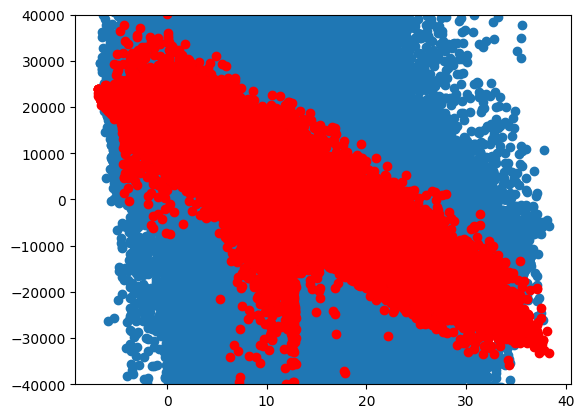

In [126]:
plt.scatter(x_data[:,2], y_target, label='Data vs Out temperature')
plt.plot(x_data[:,2], y_fitted, 'ro')
plt.ylim((-40000,40000))
plt.show()

In [128]:
def polynomial_func(inputs, a, b, c, d, e, f, g, h, i,j):
    x, y, z = inputs  # Unpack the input tuple (x, y, z)
    return (a * x**2 + b * y**2 + c * z**2 + d * x * y + e * y * z + f * x * z +
            g * x + h * y + i * z + j)


x_data = train_features.to_numpy()
y_target = train_labels.to_numpy()
initial_guesses = [1,1,1,1,1,1,1,1,1,1]

params, params_covariance = curve_fit(polynomial_func, (x_data[:,0],x_data[:,1],x_data[:,2]),y_target, p0=initial_guesses)
print("Fitted parameters:")
for name, param in zip(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'], params):
    print(f"{name} = {param}")


Fitted parameters:
a = -387.64770255599296
b = -7213.120295314775
c = 1.1042025046198072
d = -700.2979104147992
e = -2280.8023216584315
f = -176.68802405252364
g = 10440.270670594298
h = 32574.321752125397
i = 2732.9002973703446
j = -56568.443465533506


In [139]:
Pres_mean = dataset_imp['P_res'].mean()
V_mean = dataset_imp['V'].mean()
W_mean = dataset_imp['W'].mean()
T_mean = dataset_imp['Out_temperature'].mean()

def Pres_func(inputs, Cw, Cv1, Cv2, Ct):
    V,W,T = inputs

    return np.where(V<=V_mean, Pres_mean + Cw*(W-W_mean) + Cv1*(V-V_mean) + Ct*(T-T_mean), 
                    Pres_mean + Cw*(W-W_mean) + Cv2*(V-V_mean) + Ct*(T-T_mean))

initial_guesses = [80000,-10000,1000,500]

params, params_covariance = curve_fit(Pres_func, (x_data[:,0],x_data[:,1],x_data[:,2]),y_target, p0=initial_guesses)

Fitted parameters: Cw = -8478.568520514833, Cv1 = 1281.8248892879237, Cv2 = 393.58182977557783, Ct = -1235.709905533686


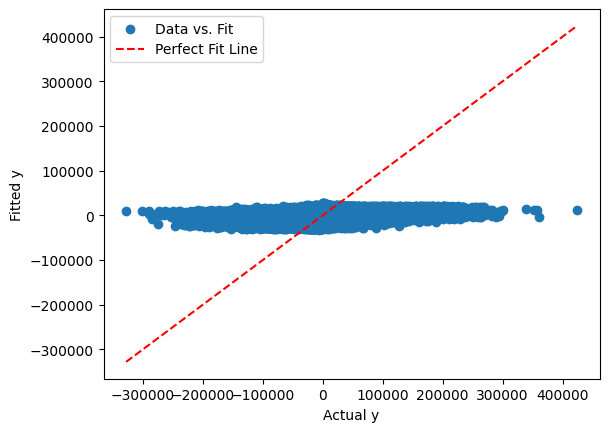

In [141]:
Cw, Cv1, Cv2, Ct = params
print(f"Fitted parameters: Cw = {Cw}, Cv1 = {Cv1}, Cv2 = {Cv2}, Ct = {Ct}")
y_fitted = Pres_func((x_data[:,0],x_data[:,1],x_data[:,2]), *params)

plt.scatter(y_target, y_fitted, label='Data vs. Fit')
plt.plot([min(y_target), max(y_target)], [min(y_target), max(y_target)], 'r--', label='Perfect Fit Line')
plt.xlabel('Actual y')
plt.ylabel('Fitted y')
plt.legend()
plt.show()

Text(0.5, 0, 'Pres')

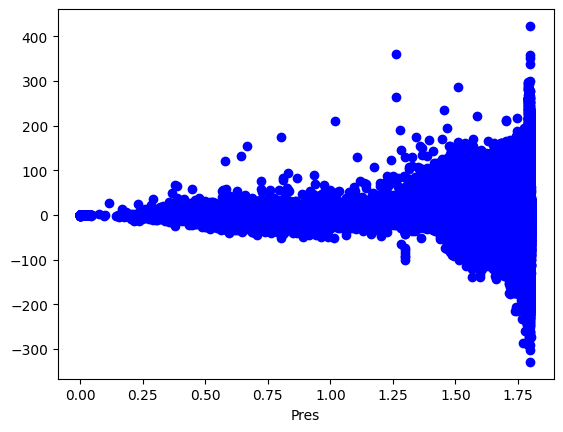

In [143]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.metrics import r2_score

V_data = x_data[:,0]
W_data = x_data[:,1]
T_data = x_data[:,2]
Pr_data = y_target

# W 
plt.scatter(W_data,(Pr_data-Pres_mean)/1000,color='blue', label='Data Points')
plt.xlabel("W")
plt.xlabel("Pres")